# Clustering substractivo

In [1]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

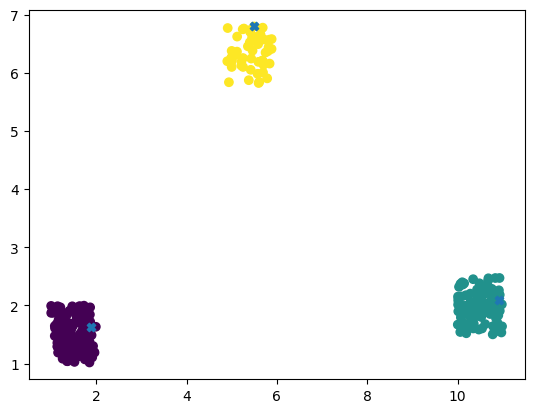

In [2]:
c1 = np.random.rand(150,2)+[1,1]
c2 = np.random.rand(100,2)+[10,1.5]
c3 = np.random.rand(50,2)+[4.9,5.8]
m = np.append(c1,c2, axis=0)
m = np.append(m,c3, axis=0)

r,c = subclust2(m,1)

plt.figure()
plt.scatter(m[:,0],m[:,1], c=r)
plt.scatter(c[:,0],c[:,1], marker='X')

# GEN Fis
## Generación de FIS a partir de agrupamiento de los datos de entrenamiento

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    exp_val = -((data - mean)**2.) / (2 * sigma**2.)
    # fix de tipos:
    exp_val = exp_val.astype(np.float32)
    return np.exp( exp_val )

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        print("nivel acti")
        print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        print("sumMu")
        print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        # fix de tipos:
        A = A.astype(np.float32)
        b = b.astype(np.float32)

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()






# Test genfis 1 entrada

--- 0.02258753776550293 seconds ---
nivel acti
[[0.3865941  0.02710355 0.9950628 ]
 [0.39420444 0.02815555 0.9963704 ]
 [0.40188342 0.02924247 0.997478  ]
 [0.4096293  0.03036522 0.9983852 ]
 [0.41744006 0.03152472 0.9990914 ]
 [0.42531383 0.03272187 0.9995961 ]
 [0.4332486  0.03395763 0.999899  ]
 [0.44124228 0.03523293 1.        ]
 [0.44929263 0.03654875 0.999899  ]
 [0.4573975  0.03790605 0.9995961 ]
 [0.46555448 0.03930581 0.9990914 ]
 [0.4737612  0.04074903 0.9983852 ]
 [0.48201522 0.04223672 0.997478  ]
 [0.49031398 0.04376986 0.9963704 ]
 [0.4986549  0.0453495  0.9950628 ]
 [0.50703526 0.04697665 0.9935563 ]
 [0.5154523  0.04865235 0.9918518 ]
 [0.52390325 0.05037767 0.98995   ]
 [0.5323852  0.05215361 0.98785245]
 [0.5408951  0.05398127 0.9855602 ]
 [0.5494301  0.05586167 0.9830746 ]
 [0.55798703 0.05779593 0.98039716]
 [0.5665627  0.05978505 0.9775296 ]
 [0.57515407 0.06183016 0.9744735 ]
 [0.58375776 0.0639323  0.97123075]
 [0.5923704  0.06609255 0.96780324]
 [0.6009888  0.06

array([ -606.228   ,  6068.1763  ,  -434.35782 ,   -13.483757,
        -433.29108 , -6495.3228  ], dtype=float32)

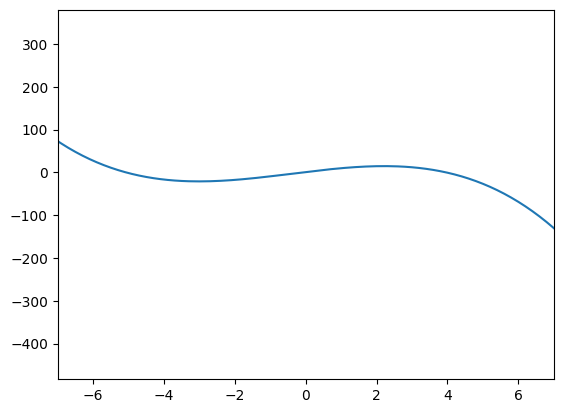

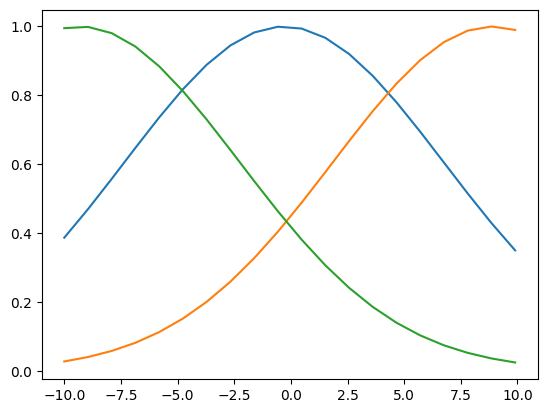

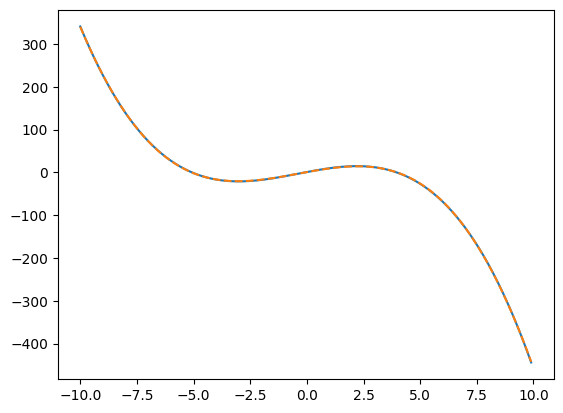

In [4]:
#test genfis 1D
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

data_x = np.arange(-10,10,0.1)
data_y = -0.5*data_x**3-0.6*data_x**2+10*data_x+1 #my_exponential(9, 0.5,1, data_x)

plt.plot(data_x, data_y)
# plt.ylim(-20,20)
plt.xlim(-7,7)

data = np.vstack((data_x, data_y)).T

fis2 = fis()
fis2.genfis(data, 1.1)
fis2.viewInputs()
r = fis2.evalfis(np.vstack(data_x))

plt.figure()
plt.plot(data_x,data_y)
plt.plot(data_x,r,linestyle='--')

fis2.solutions

# r1 = data_x*-2.29539539+ -41.21850973
# r2 = data_x*-15.47376916 -79.82911266
# r3 = data_x*-15.47376916 -79.82911266
# plt.plot(data_x,r1)
# plt.plot(data_x,r2)
# plt.plot(data_x,r3)

# Test genfis 2 entradas

--- 0.37119030952453613 seconds ---
nivel acti
[[3.3861819e-01 5.4100766e-03 3.8121685e-02 9.0205565e-02 9.9170470e-01]
 [3.6014768e-01 6.1097103e-03 4.4067513e-02 9.0055414e-02 9.9667358e-01]
 [3.8177186e-01 6.8768687e-03 5.0771255e-02 8.9606442e-02 9.9833542e-01]
 ...
 [4.9189344e-02 7.8018063e-01 3.9151505e-02 2.0615418e-02 7.3768414e-04]
 [4.4733226e-02 7.5335753e-01 3.8697578e-02 1.7597765e-02 6.3391333e-04]
 [4.0545475e-02 7.2503692e-01 3.8121685e-02 1.4971862e-02 5.4292794e-04]]
sumMu
[[1.4640602]
 [1.4970539]
 [1.5273619]
 ...
 [0.8898745]
 [0.85502  ]
 [0.8192189]]
[  5.8628488   9.258725  -37.29977    -1.3963176  -5.7685094 -80.125916
  11.5229645 -11.435247  180.45782   -10.694585  -12.339828    5.48342
  13.697228    6.936519  114.99756  ]


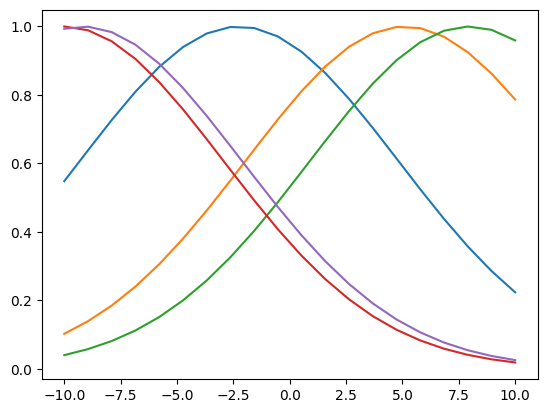

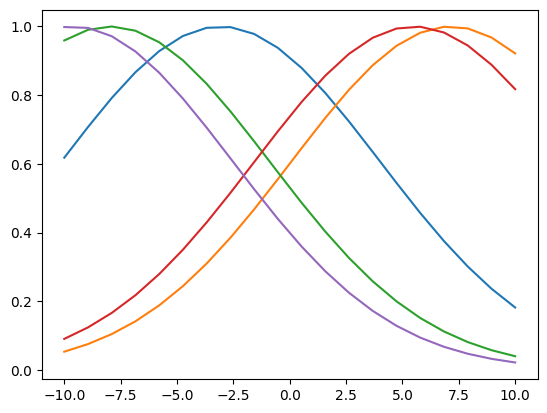

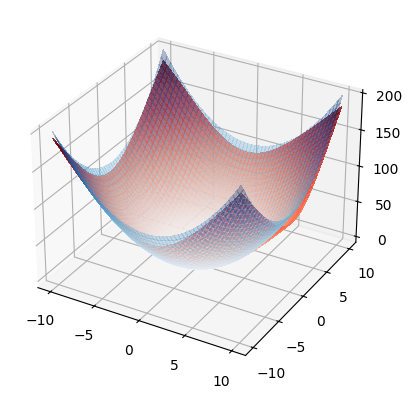

In [5]:
from matplotlib import cm

x=np.linspace(-10,10,50)
X,Y = np.meshgrid(x,x)
Z = X**2+Y**2

data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

fis3 = fis()
fis3.genfis(data,1.2)
fis3.viewInputs()

r = fis3.evalfis(np.vstack((X.ravel(), Y.ravel())).T)
r = np.reshape(r, X.shape)


fig = plt.figure()
ax = fig.add_subplot(projection = '3d') #fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.Blues,
                        linewidth=0, antialiased=False, alpha=0.3)

surf = ax.plot_surface(X,Y, r, cmap=cm.Reds,
                        linewidth=0, antialiased=False, alpha=0.8)


In [6]:
fis2.rules

array([[-0.3],
       [ 8.9],
       [-9.3]])

In [7]:
fis3.rules

array([[ -2.24489796,  -3.06122449],
       [  5.10204082,   7.14285714],
       [  7.95918367,  -7.95918367],
       [-10.        ,   5.51020408],
       [ -9.18367347,  -9.59183673]])